In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [5]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [6]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
0,NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
1,NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
2,NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
3,NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
4,NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [7]:
datos.tail()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
55387,NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
55388,NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
55389,NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
55390,NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
55391,NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [8]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [9]:
n_periods = 5*24

In [10]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314''GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [11]:
columna = columns[5]
columna

'GICIS306'

In [12]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [27]:
def AIC_accuracy(train,test):
        fcc = []
        
        data = train[columna].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        #model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        fcc.append(fc)
        return(fcc, model)

In [14]:
    data2 = datos[['hora',columna]]
    data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    #data2 = data2.dropna()
    data2

,hora,GICIS306
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0
...,...,...
2020-03-09 19:00:00,20,0.0
2020-03-09 20:00:00,21,0.0
2020-03-09 21:00:00,22,0.0


***

In [63]:
    #Seleccion de y_train y y_test
    n = 1
    test = (data2.iloc[-(1*24):,:])   # INFO DE TEST
    train = data2.drop(data2.index[:(1*24)]) # QUITANDO TEST PARA TRAIN

In [64]:
train, test

(                     hora  GICIS306
 fecha_hora                         
 2020-01-02 00:00:00     1       0.0
 2020-01-02 01:00:00     2       0.0
 2020-01-02 02:00:00     3       0.0
 2020-01-02 03:00:00     4       0.0
 2020-01-02 04:00:00     5       0.0
 ...                   ...       ...
 2020-03-09 19:00:00    20       0.0
 2020-03-09 20:00:00    21       0.0
 2020-03-09 21:00:00    22       0.0
 2020-03-09 22:00:00    23       0.0
 2020-03-09 23:00:00    24       0.0
 
 [1632 rows x 2 columns],                      hora  GICIS306
 fecha_hora                         
 2020-03-09 00:00:00     1       0.0
 2020-03-09 01:00:00     2       0.0
 2020-03-09 02:00:00     3       0.0
 2020-03-09 03:00:00     4       0.0
 2020-03-09 04:00:00     5       0.0
 2020-03-09 05:00:00     6       0.0
 2020-03-09 06:00:00     7       0.0
 2020-03-09 07:00:00     8       0.0
 2020-03-09 08:00:00     9       0.0
 2020-03-09 09:00:00    10       0.0
 2020-03-09 10:00:00    11       0.0
 2020-03-09

In [76]:
fcc = []

#MODELO ARIMA
y_train = train[columna]
        
model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
            test='adf',       # use adftest to find optimal 'd'
            max_p=5, max_q=5, # maximum p and q
            m=12,              # frequency of series
            d=None,           # let model determine 'd'
            seasonal=False)   

print(model)

ARIMA(maxiter=50, method='lbfgs', order=(4, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


In [77]:
model.fit(y_train.values)

ARIMA(maxiter=50, method='lbfgs', order=(4, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [78]:
# Predicción
fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
fcc.append(fc)

In [79]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1632
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -8275.757
Date:                Thu, 26 Mar 2020   AIC                          16569.513
Time:                        20:16:05   BIC                          16618.091
Sample:                             0   HQIC                         16587.534
                               - 1632                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2644      2.166      2.430      0.015       1.019       9.510
ar.L1          2.6201      0.026    101.405      0.000       2.569       2.671
ar.L2         -3.1646      0.059    -53.272      0.000      -3.281      -3.048
ar.L3          2.0686      0.054     38.194      0.000       1.962       2.175
ar.L4         -0.6046      0.022    -27.389      0.000      -0.648      -0.561
ma.L1         -0.9532      0.030    -31.963      0.000      -1.012      -0.895
ma.L2          0.6159      0.035     17.421      0.000       0.547       0.685
ma.L3          0.1779      0.026      6.912      0.000       0.127       0.228
sigma2      1486.5875     28.893     51.451      0.000    1429.958    1543.217
===================================================================================
Ljung-Box (Q):                      273.00   Jarque-Bera (JB):             22647.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             1.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
fc

array([ 6.2424477 , 16.64790174, 28.01466956, 38.89437006, 49.17981372,
       58.92133853, 67.52957582, 73.95497969, 77.48171081, 78.30597136,
       77.39235091, 75.80097139, 74.09555876, 72.27503348, 70.16243721,
       67.82275007, 65.64316758, 64.06712337, 63.27253842, 63.08397677,
       63.16194836, 63.27210735, 63.40431384, 63.67739231])

In [81]:
fcc

[array([ 6.2424477 , 16.64790174, 28.01466956, 38.89437006, 49.17981372,
        58.92133853, 67.52957582, 73.95497969, 77.48171081, 78.30597136,
        77.39235091, 75.80097139, 74.09555876, 72.27503348, 70.16243721,
        67.82275007, 65.64316758, 64.06712337, 63.27253842, 63.08397677,
        63.16194836, 63.27210735, 63.40431384, 63.67739231])]

In [82]:
    dias = []
    pronostico = pd.DataFrame(fc)
        
    start=datos['fecha'][0]
    pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
    pronostico.index = pronostico.index.map(str)

In [83]:
pronostico

,0
2020-03-09 00:00:00,6.242448
2020-03-09 01:00:00,16.647902
2020-03-09 02:00:00,28.014670
2020-03-09 03:00:00,38.894370
2020-03-09 04:00:00,49.179814
2020-03-09 05:00:00,58.921339
2020-03-09 06:00:00,67.529576
2020-03-09 07:00:00,73.954980
2020-03-09 08:00:00,77.481711
2020-03-09 09:00:00,78.305971


In [84]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00    0.0
2020-02-20 00:00:00    0.0
2020-02-20 01:00:00    0.0
2020-02-20 02:00:00    0.0
2020-02-20 03:00:00    0.0
                      ... 
2020-03-09 19:00:00    0.0
2020-03-09 20:00:00    0.0
2020-03-09 21:00:00    0.0
2020-03-09 22:00:00    0.0
2020-03-09 23:00:00    0.0
Name: GICIS306, Length: 457, dtype: float64

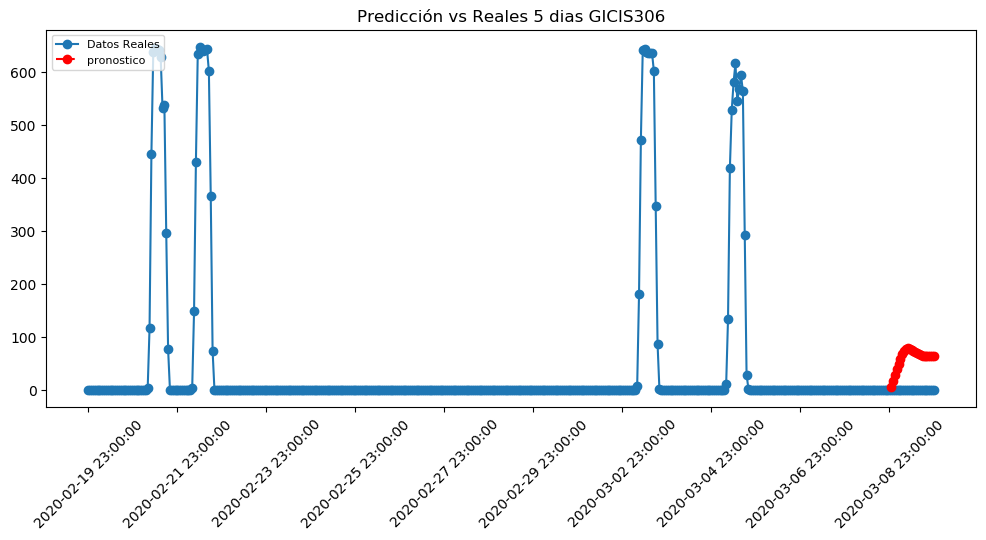

In [85]:
    arange_dates = []
    arange_no = []
    arange = datos[columna][-1-19*24:].index
    for i in range(0,len(arange),48):
        arange_dates.append(arange[i])
        arange_no.append(i)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
    plt.plot(pronostico, 'o--', label='pronostico',color ='r')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.xticks(arange_no,arange_dates,rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [ ]:
Forecasts = pd.DataFrame(fcc).dropna().T

In [28]:
Forecasts.index = test.index
Forecasts.columns = test.columns
round(Forecasts,2)

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.60,20.59,74.99,...,126.95,99.54,102.01,67.72,20.55,0.0,-0.0,-0.0,-0.0,-0.0
2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.62,24.44,102.40,...,170.24,126.88,125.57,67.72,19.35,0.0,-0.0,-0.0,-0.0,-0.0
2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.16,30.97,112.43,...,184.99,151.95,131.01,67.72,21.15,0.0,-0.0,-0.0,-0.0,-0.0
2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.19,33.27,116.10,...,190.02,163.66,132.26,67.72,20.03,0.0,-0.0,-0.0,-0.0,-0.0
2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.67,35.54,117.44,...,191.74,171.31,132.55,67.72,21.65,0.0,-0.0,-0.0,-0.0,-0.0


In [29]:
test

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,134.0,418.0,...,567.0,593.0,564.0,292.0,29.0,2.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [31]:
new_mapes

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.945346,0.846377,0.820606,...,0.776094,0.832134,0.819123,0.768066,0.291473,1.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0


In [32]:
new_mapes[[ 'Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]

,Hora 8,Hora 9,Hora 10,Hora 11,Hora 12,Hora 13,Hora 14,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19
2020-03-05,0.945346,0.846377,0.820606,0.796447,0.782368,0.791736,0.920447,0.776094,0.832134,0.819123,0.768066,0.291473
2020-03-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
np.mean(new_mapes)

Hora 1     0.000000
Hora 2     0.000000
Hora 3     0.000000
Hora 4     0.000000
Hora 5     0.000000
Hora 6     0.000000
Hora 7     0.000000
Hora 8     0.189069
Hora 9     0.169275
Hora 10    0.164121
Hora 11    0.159289
Hora 12    0.156474
Hora 13    0.158347
Hora 14    0.184089
Hora 15    0.155219
Hora 16    0.166427
Hora 17    0.163825
Hora 18    0.153613
Hora 19    0.058295
Hora 20    1.000000
Hora 21    0.000000
Hora 22    0.000000
Hora 23    0.000000
Hora 24    0.000000
dtype: float64

In [34]:
np.mean(np.mean(new_mapes[['Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]))

0.15650364207668654

In [35]:
import pandas as pd
medidasdepresicion = ['MAD','MAPE','PMAD','MSE','RMSE']
dfpresicion = pd.DataFrame(columns=medidasdepresicion)
dfpresicion.MAPE = 0.2
dfpresicion

,MAD,MAPE,PMAD,MSE,RMSE
